# Base - Reinforcement

- author: Marcelo de Gomensoro Malheiros
- revision: 2020-08
- license: MIT (attribution is not required but greatly appreciated)

## Reinforcement model

\begin{align}
\\
\frac{\partial{c}}{\partial{t}} &= \gamma (t - w - c) (t - c) (t + w - c) + D_c \nabla^2 c
\tag{3}
\\
\gamma &= \frac{3 \sqrt{3}}{2 w^2}
\end{align}

In [42]:
from scipy import ndimage

def reinforcement_model(mc, kc, lc, dc, dt, t, w, g, wrap):

    if wrap: ndimage.convolve(mc, kc, output=lc, mode='wrap')
    else:    ndimage.convolve(mc, kc, output=lc, mode='reflect')

    global c
    c = mc + ((t - w - mc) * (t - mc) * (t + w - mc) * g + dc * lc) * dt

## Simulation

Parameter list, with default values shown:
- `threshold=1` - threshold parameter
- `width=1` - width parameter
- `scale=1` - overall scale of the pattern
- `speed=100` - percent of default time step
- `start=0` - start iteration counter
- `stop=1000` - final iteration counter
- `time=None` - simulation time (in milliseconds), used instead of `stop` and taking into account `speed`
- `use_c=False` - use previous values for C?
- `wrap=True` - use toroidal domain if true, non-flux boundary otherwise
- `seed=1` - random seed
- `ini_c=0` - initial constant values for C
- `var_c=2` - added randomness magnitude for C
- `shape=40` - domain dimension
- `axis=False` - show domain size?
- `cmap='inferno'` - Matplotlib colormap used
- `first=False` - show initial state?
- `info=False` - show concentrations intervals after simulation?
- `limit=None` - plot images with given dimension
- `show='c'` - reagents to show (can be the empty string)
- `size=2` - image output size
- `snap=4` - how many captures are shown (can also be a list of iteration counts)
- `detail=None` - show 1-D plot at given domain row (A in orange and B in blue)
- `extent=(-0.2, 2.2)` - upper and lower values for 1-D plot
- `func=None` - auxiliary function
- `out=None` - output file name (PDF/PNG/JPG/...)
- `dpi=100` - resolution for output
- `interpolation='bilinear'` - used when converting a matrix to an image
- `detect=False` - detect constant-valued and stable pattern states, besides numerical problems?
- `model=reinforcement_model` - model function used

Global variables set after the simulation is run:
- `c` - final concentrations for C
- `sim` - information about the simulation (can be used as an object or a dict)

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# reinforcement: cubic autocatalytic reinforcement model - v6.2

kernel_c = np.array([[1, 4, 1], [4, -20, 4], [1, 4, 1]]) / 6

class Bunch(dict):
    def __init__(self, dictionary):
        dict.__init__(self, dictionary)
        self.__dict__.update(dictionary)

def reinforcement(threshold=1, width=1, scale=1, speed=100, start=0, stop=1000, time=None, use_c=False, wrap=True,
                  seed=1, ini_c=0, var_c=2, shape=40,
                  axis=False, cmap='inferno', first=False, info=False, limit=None, show='c', size=2, snap=4,
                  detail=None, extent=(-0.2, 2.2), func=None, out=None, dpi=100, interpolation='bilinear',
                  detect=False, model=reinforcement_model):

    # simulation init
    
    diff_c = scale
    delta_t = 0.01 * speed / 100
    if time: stop = int(time * 100 / speed) + start

    global sim, c
    np.random.seed(seed)
    if type(shape) == int: shape = (shape, shape)
    if not use_c:
        c = np.full(shape, ini_c, dtype=float)
        if var_c != 0: c += np.random.random_sample(shape) * var_c
    lap_c = np.empty_like(c)
    is_nan = is_stable = is_uniform = last_c = False
    if info:
        high_c = - float('inf')
        low_c = float('inf')
        
    # plotting helper functions

    def draw(matrix, row):
        if axis: axes[row, col].axis('on')
        axes[row, col].imshow(matrix, cmap=cmap, interpolation=interpolation)
        axes[row, col].set_anchor('N')
        if limit:
            axes[row, col].set_xbound(0, limit[1] - 1)
            axes[row, col].set_ybound(0, limit[0] - 1)

    def plot():
        axes[0, col].set_title(iteration)
        row = 0
        if detail:
            if 'c' in show:
                t = c.copy()
                t[detail - 1,:] = t[detail + 1,:] = c.min()
                draw(t, row); row += 1
        else:
            if 'c' in show: draw(c, row); row += 1

        if detail:
            axes[row, col].axis('on')
            axes[row, col].get_xaxis().set_visible(False)
            axes[row, col].grid()
            axes[row, col].plot((threshold - width,) * shape[1], color='orange', linestyle='--')
            axes[row, col].plot((threshold,        ) * shape[1], color='orange', linestyle='--')
            axes[row, col].plot((threshold + width,) * shape[1], color='orange', linestyle='--')
            axes[row, col].plot(c[detail], color='blue')
            axes[row, col].set_anchor('N')
            axes[row, col].set_ybound(extent[0], extent[1])

    # plotting init
    
    ax = ay = col = rows = 0
    if 'c' in show: rows += 1
    if detail: rows += 1
    if type(snap) == int:
        if first: snap = np.linspace(start, stop, snap, dtype=int)
        else: snap = np.linspace(start, stop, snap + 1, dtype=int)[1:]
    cols = len(snap)
    fig, axes = plt.subplots(rows, cols, squeeze=False, figsize=(cols * size, rows * size + 0.01)) #HACK plot 3.2.x
    for ay in axes:
        for ax in ay: ax.axis('off')
    if first and show:
        iteration = start
        plot()
        col += 1
    if type(limit) == int: limit = (limit, limit)

    # simulation loop

    gamma = 3 * np.sqrt(3) / (2 * width * width)
        
    for iteration in range(start + 1, stop + 1):
        if func: func(iteration, seed)

        if detect and iteration % 100 == 0: last_c = c.copy()
        if c.shape != shape:
            shape = c.shape
            lap_c = np.empty_like(c)
        
        model(c, kernel_c, lap_c, diff_c, delta_t, threshold, width, gamma, wrap)
                
        if info:
            high_c = max(c.max(), high_c)
            low_c = min(c.min(), low_c)
        if detect and iteration % 100 == 0:
            if c.ptp() < 0.001: is_uniform = True
            elif np.isnan(np.sum(c)): is_nan = True
            elif type(last_c) != bool and np.allclose(c, last_c, atol=0.00001, rtol=0): is_stable = True
            last_c = c.copy()

        if is_stable or iteration in snap:
            if show: plot()
            col += 1
        if is_stable or is_uniform or is_nan: break
    
    # finalization
    
    if info:
        min_c, max_c = c.min(), c.max()
        print('C [{:.2f}, {:.2f}] <{:.2f}, {:.2f}>'.format(min_c, max_c, low_c, high_c), end='  ')
        if is_stable: print('stability of C at {}'.format(iteration))
        elif is_uniform: print('uniformity of C at {}'.format(iteration))
        elif is_nan: print('NaN found in C at {}'.format(iteration))

    if col == 0 or not show: plt.close()
    else:
        plt.show()
        if out: fig.savefig(out, bbox_inches='tight', dpi=dpi)

    del axes, ax, ay, col, cols, draw, fig, gamma, last_c, lap_c, plot, rows
    sim = Bunch(locals())

## Simple validation

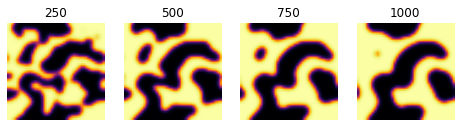

In [44]:
reinforcement()

## Usage examples

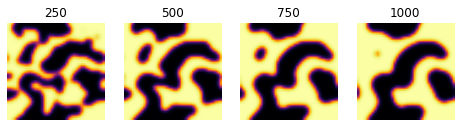

In [45]:
# change in the initial state, compensated by the threshold and width parameters, yields the same pattern
reinforcement(ini_c=2, var_c=1, threshold=2.5, width=0.5, scale=1, stop=1000)

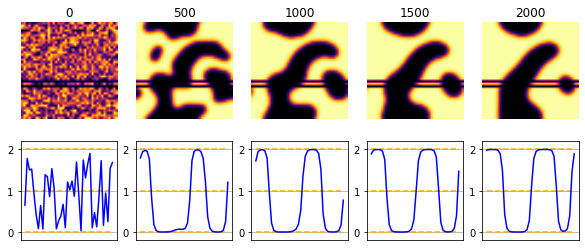

In [46]:
# show C and 1D detail view (dashed lines indicate the t-w, t and t+w levels)
# show initial state (iteration 0)
reinforcement(detail=25, first=True, snap=5, stop=2000, scale=1.2)

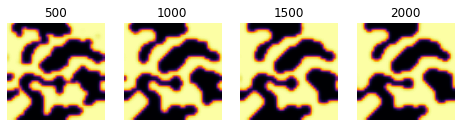

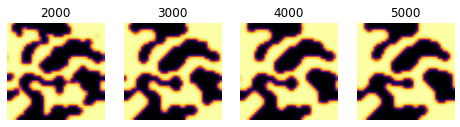

In [47]:
# set non-zero 'start' iteration count
# 'time' adjusts number of iterations accordingly to speed
reinforcement(scale=0.6, stop=2000)
reinforcement(scale=0.6, start=1000, time=2000, speed=50)

In [48]:
# skip output, but still stop at a stable pattern
reinforcement(detect=True, info=True, scale=0.1, show='')

C [0.00, 2.00] <0.00, 2.00>  stability of C at 600


In [49]:
# stop prematurely when concentrations turn constant
reinforcement(detect=True, threshold=2)
print('is uniform?', sim.is_uniform)

is uniform? True


In [50]:
# fields available for simulation object
for i in sorted(sim):
    print(i + '=' + repr(sim[i]))

axis=False
cmap='inferno'
delta_t=0.01
detail=None
detect=True
diff_c=1
dpi=100
extent=(-0.2, 2.2)
first=False
func=None
info=False
ini_c=0
interpolation='bilinear'
is_nan=False
is_stable=False
is_uniform=True
iteration=200
limit=None
model=<function reinforcement_model at 0x7f27c8aabc20>
out=None
scale=1
seed=1
shape=(40, 40)
show='c'
size=2
snap=array([ 250,  500,  750, 1000])
speed=100
start=0
stop=1000
threshold=2
time=None
use_c=False
var_c=2
width=1
wrap=True
